# TP1 Louis Hémadou

# Get Data and load packages

In [1]:
import pandas as pd
import numpy as np
#from google.colab import files

In [2]:
#files.upload()

In [3]:
data = pd.read_csv('./housedata/data.csv')

In [4]:
data

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
0,2014-05-02 00:00:00,3.130000e+05,3.0,1.50,1340,7912,1.5,0,0,3,1340,0,1955,2005,18810 Densmore Ave N,Shoreline,WA 98133,USA
1,2014-05-02 00:00:00,2.384000e+06,5.0,2.50,3650,9050,2.0,0,4,5,3370,280,1921,0,709 W Blaine St,Seattle,WA 98119,USA
2,2014-05-02 00:00:00,3.420000e+05,3.0,2.00,1930,11947,1.0,0,0,4,1930,0,1966,0,26206-26214 143rd Ave SE,Kent,WA 98042,USA
3,2014-05-02 00:00:00,4.200000e+05,3.0,2.25,2000,8030,1.0,0,0,4,1000,1000,1963,0,857 170th Pl NE,Bellevue,WA 98008,USA
4,2014-05-02 00:00:00,5.500000e+05,4.0,2.50,1940,10500,1.0,0,0,4,1140,800,1976,1992,9105 170th Ave NE,Redmond,WA 98052,USA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4595,2014-07-09 00:00:00,3.081667e+05,3.0,1.75,1510,6360,1.0,0,0,4,1510,0,1954,1979,501 N 143rd St,Seattle,WA 98133,USA
4596,2014-07-09 00:00:00,5.343333e+05,3.0,2.50,1460,7573,2.0,0,0,3,1460,0,1983,2009,14855 SE 10th Pl,Bellevue,WA 98007,USA
4597,2014-07-09 00:00:00,4.169042e+05,3.0,2.50,3010,7014,2.0,0,0,3,3010,0,2009,0,759 Ilwaco Pl NE,Renton,WA 98059,USA
4598,2014-07-10 00:00:00,2.034000e+05,4.0,2.00,2090,6630,1.0,0,0,3,1070,1020,1974,0,5148 S Creston St,Seattle,WA 98178,USA


# Preprocessing
Convert date to int

In [5]:
data['date_int'] = pd.to_datetime(data['date']).dt.strftime("%Y%m%d").astype(int)

Convert cities to one hot

In [6]:
city = pd.get_dummies(pd.Categorical(data['city']), prefix='city')

convert observation to numpy

In [7]:
X = np.concatenate([data[['date_int', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated']].to_numpy(), city.to_numpy()], axis=1)

In [8]:
X.shape

(4600, 57)

convert price to numpy

In [9]:
Y = data['price'].to_numpy()
Y.shape

(4600,)

split train/val/test sets

In [10]:
r = np.random.permutation(len(X))
X_train = X[r[0:3500], :]
Y_train = Y[r[0:3500]]
X_val = X[r[3500:4000], :]
Y_val = Y[r[3500:4000]]
X_test = X[r[4000:], :]
Y_test = Y[r[4000:]]

# Classification

First, split the prices into 2 categories of equal sizes (split by median price) and try to predict the category of the houses. We will measure the perfomances of our prediction with the accuracy (percentage of correct predictions).

Here is a list of things to try:
- Strandardize data (each component has zero mean and unit variance)
- Orthogonalize data (perform PCA, try with and without whitening)
- Different classifiers (LDA, logistic regression, k-NN with varying k)
Among thoses choices, select the best performing model on val and evaluate it on test.

Then, split the prices into 5 categories and try to find the best k-NN classifier (including the data normalization). Hyperparameters (pre-processing steps, number of neighbors) are always chosen using the validation set. Report the accuracy on the test set and analyze your results (how confident you are in the classifier, what are the difficulties, what may improve the classification, what bias did you find, etc).


In [11]:
import numpy as np
from numpy.linalg import eigh
import matplotlib.pyplot as plt

def standardize(X):
    eps = 1e-8 # In case where std = 0
    X_s = (X-np.mean(X, axis = 0))/(np.std(X, axis = 0) + eps)
    return X_s

def normalize(X):
    eps = 1e-8 # In case where max = min
    X_n = (X-np.min(X, axis=0))/(np.max(X, axis = 0)-np.min(X, axis=0)+eps)
    return X_n

X_t = standardize(X_train)
print(str(X_t.shape[1]) + " features")

57 features


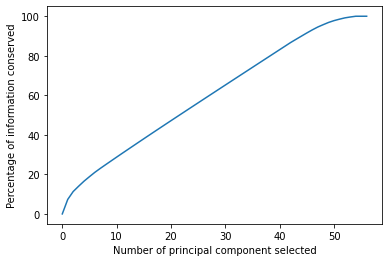

97.78775875674107% of data conserved


In [12]:
def pca(X, n_comp, whitening = True, visual = False):
    
    K = np.cov(X.T) # Correlation matrix
    eig_values, eig_vectors = eigh(K) # Sorted eigenvalues and eigenvectors

    eig_values = eig_values[::-1]
    eig_vectors = eig_vectors.T[::-1]
    
    def data_saved(m): # Which percentage of data is saved if we select the m greatest eigenvalues ?
        return sum(eig_values[:m])/sum(eig_values)
    
    if visual:
        plt.figure(1)
        plt.xlabel("Number of principal component selected")
        plt.ylabel("Percentage of information conserved")
        n, p = X.shape
        x_axis = range(0, p)
        y_axis = [100*data_saved(x) for x in x_axis]
        plt.plot(x_axis,y_axis)
        plt.show()
        print(str(100*data_saved(n_comp)) + "% of data conserved")

    # Orthogonalizing data

    new_base = eig_vectors[:n_comp]
    X_pca = np.dot(X, new_base.T)
    
    if whitening:
        X_pca = np.dot(X_pca, np.diag(eig_values[0:n_comp]**(-1/2)))
        
    return X_pca

X_t = standardize(X_train)
n_comp = 50
X_t_pca = pca(X_t, n_comp, visual = True)

On n'observe pas une grande plus value à ne conserver que les premières composantes principales. On peut néanmoins éliminer les quelques features ayant une variance nulle.

In [15]:
def sig(x):
    return 1/ (1 + np.exp(-x))

def add_ones(X):
    """Adds a column of 1 at the
    beginning of X"""
    new_X = np.array([np.ones(X.shape[0])] + [sample for sample in X.T])
    return new_X.T



def logistic_regression(X, Y, n_iter = 100, delta = 0.001):
    """Returns coefficients of the logistic
    regression which predicts Y with X"""
    
    n_feature = X.shape[1]
    beta = np.zeros(n_feature) # Logistic regression coefficients
    
    def grad_logistic(X, Y, beta):
        """Gradient of loss function"""
        n_sample = X.shape[0]
        Y_pred = sig(np.dot(X, beta))
        dbeta = np.sum( [(Y_pred[i]-Y[i]) * X[i] for i in range(n_sample)], axis=0)
        return dbeta
        
    for i in range(n_iter): # Gradient algorithm
        dbeta = grad_logistic(X, Y, beta)
        beta = beta - delta * dbeta
        print('training, iteration: '+str(i+1)+'/'+str(n_iter)+'\r', sep=' ', end='', flush=True)
    print("\r")
    
    return beta

n_comp = 40

X_pca = add_ones(pca(standardize(X_train), n_comp)) # Data standardized + orthogonalized
X_val_pca = add_ones(pca(standardize(X_val), n_comp))
X_s = add_ones(standardize(X_train)) # Data only standardized
X_val_s = add_ones(standardize(X_val))

med = np.median(Y_train) # Creating "high" and "low" prices
Y_t = (Y_train > med).astype(int) # Training set
Y_v = (Y_val > med).astype(int) # Validation set

beta_pca = logistic_regression(X_pca, Y_t)
Y_pred_pca = (sig(np.dot(X_val_pca, beta_pca)) > 1/2).astype(int)

beta_s = logistic_regression(X_s, Y_t)
Y_pred_s = (sig(np.dot(X_val_s, beta_s)) > 1/2).astype(int)

def accuracy_bool(Y, Y_pred):
    """Measures the accuracy of a
    boolean prediction"""
    
    good = 0
    
    n_sample_val = len(Y)
    for i in range(n_sample_val):
        if Y_pred[i] == Y[i]:
            good +=1
            
    good /= n_sample_val
    
    return 100*good

acc_2 = accuracy_bool(Y_v, Y_pred_pca)    
acc_1 = accuracy_bool(Y_v, Y_pred_s)

print("Accuracy for data standardized and orthogonalized: " + str(acc_2) + "%")
print("Accuracy for data standardized: " + str(acc_1) + "%")

training, iteration: 100/100
training, iteration: 100/100
Accuracy for data standardized and orthogonalized: 51.800000000000004%
Accuracy for data standardized: 83.6%


In [16]:
def sort_by_nearest(sample, X):
    """Sorting neighbors by smallest distance for every validation sample
    """
    indexes = [i for i in range(X_t.shape[0])]
    
    def distance(x):
        return np.linalg.norm(x[1] - sample)

    neigh = list(zip(indexes, X))
    
    neigh.sort(key = distance)
    
    sorted_ind = [n[0] for n in neigh]
    
    return sorted_ind

def create_NN(X_t, X_v):   
    NN = []
    n_val_sample = len(X_v)
    for i in range(n_val_sample):
        x_v = X_v[i]
        print('Creating nearest neighbors, sample: '+str(i+1)+'/'+str(len(X_v))+'\r', sep=' ', end='', flush=True)
        NN.append(sort_by_nearest(x_v, X_t))
        
    return NN

X_s = standardize(X_train)
X_val_s = standardize(X_val)
NN = create_NN(X_s, X_val_s) # ~30 seconds of computing

Accuracy of kNN algorithm with 2 classes: 84.8 %
Accuracy of kNN algorithm with 3 classes: 71.0 %
Accuracy of kNN algorithm with 4 classes: 63.4 %
Accuracy of kNN algorithm with 5 classes: 53.400000000000006 %


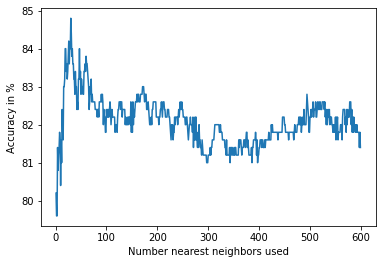

best k: 30


In [19]:
def list_to_class(L, k):
    """Divides a list L into k groups
    """
    L2 = np.sort(L)
    n = len(L)
    boundaries = [L2[int(j*n/k)] for j in range(1, k)] + [np.min(L), np.max(L)]
    boundaries.sort()
    out = []
    for l in L:
        for i in range(k):
            if boundaries[i] <= l <= boundaries[i+1]:
                out.append(i)
                break
    return out

def kNN(NN, Y_t, n_class, k):
    Y_tr = list_to_class(Y_t, n_class)
    Y_pred = []
    for n in NN:
        kNN = n[0:k]
        kNN_classes = [Y_tr[n] for n in kNN]
        kNN_classes_occ = [kNN_classes.count(i) for i in range(n_class)]
        Y_pred.append(np.argmax(kNN_classes_occ))
    return Y_pred

n_class_values = range(2, 6)
for n_class in n_class_values:
    Y_va = list_to_class(Y_val, n_class)
    Y_pred = kNN(NN, Y_train, n_class, 30)
    acc = accuracy_bool(Y_va, Y_pred)
    print("Accuracy of kNN algorithm with " + str(n_class) + " classes: " + str(acc) + " %")

def best_k(NN, Y_t, Y_v, n_class):
    max_k = 600
    k_values = range(1, max_k)
    scores = []
    Y_va = list_to_class(Y_v, n_class)
    for k in k_values:
        print('Finding best k: '+str(k)+'/'+str(max_k)+'\r', sep=' ', end='', flush=True)
        scores.append(accuracy_bool(Y_va, kNN(NN, Y_t, n_class, k)))
    
    plt.figure(1)
    plt.plot(k_values, scores)
    plt.xlabel("Number nearest neighbors used")
    plt.ylabel("Accuracy in %")
    plt.show()
    
    ind_best = np.argmax(scores)
    print("best k: " + str(k_values[ind_best]))
    
best_k(NN, Y_train, Y_val, 2) # ~30 seconds of computing

Les meilleurs résultats sont obtenus avec la régression logistique, avec des données simplement standardisées. Je suspecte néanmoins un problème concernant les données standardisées et orthogonalisées, on obtient quelque fois des résultats inférieurs aux résultats d'une prédiction aléatoire. Voyons enfin ce que la régression logistique donne sur le groupe de test.

In [21]:
X_s = add_ones(standardize(X_train)) # Data only standardized
X_test_s = add_ones(standardize(X_test))

med = np.median(Y_train) # Creating "high" and "low" prices
Y_t = (Y_train > med).astype(int)
Y_te = (Y_test > med).astype(int)

beta_s = logistic_regression(X_s, Y_t)
Y_pred_s = (sig(np.dot(X_test_s, beta_s)) > 1/2).astype(int)
acc = accuracy_bool(Y_te, Y_pred_s)    

print("Accuracy of the best classifier on test samples: " + str(acc) + "%")


training, iteration: 100/100
Accuracy of the best classifier on test samples: 83.5%


# k-NN regression

Try now to directly regressthe prices using a k-NN approach. The price is predicted as the average of the prices among the k nearest neighbors. As before, use the validation set to select the hyper parameters and analyze your best results.

Error with kNN regression: 32.71468284639236


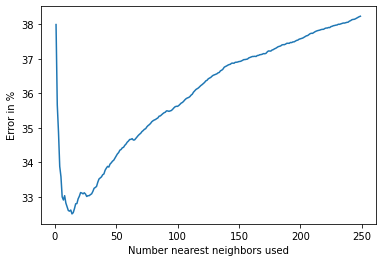

best k: 14


In [22]:
def kNN_regression(NN, Y, k):
    Y_pred = []
    for n in NN:
        kNN = n[0:k]
        Y_pred.append((1/k) * sum(Y[nn] for nn in kNN)) # Mean of k nearest neighbors
    return Y_pred

def accuracy(Y_pred, Y):
    """Measures accuracy of a
    regression prediction"""
    error = np.abs(Y_pred - Y)
    return 100*np.mean(error)/np.mean(Y) # Mean experimental error  

Y_pred = kNN_regression(NN, Y_train, 10)

acc = accuracy(Y_pred, Y_val)

print("Error with kNN regression: " + str(acc))
 
    
def best_k_regression(NN, Y_t, Y_v):
    max_k = 250
    k_values = range(1, max_k)
    scores = []
    for k in k_values:
        print('Finding best k: '+str(k)+'/'+str(max_k)+'\r', sep=' ', end='', flush=True)
        scores.append(accuracy(kNN_regression(NN, Y_t, k), Y_v))
    plt.figure(1)
    plt.plot(k_values, scores)
    plt.xlabel("Number nearest neighbors used")
    plt.ylabel("Error in %")
    plt.show()
    
    best_k = np.argmin(scores)
    print("best k: " + str(k_values[best_k]))
    return best_k
best_k = best_k_regression(NN, Y_train, Y_val)

Maintenant que nous avons trouvé le meilleur k pour le groupe de validation, regardons la précision de ce régresseur sur les données test.

In [23]:
X_s = standardize(X_train)
X_test_s = standardize(X_test)
NN = create_NN(X_train, X_test_s) # ~30 seconds of computing
Y_pred = kNN_regression(NN, Y_train, best_k)

acc = accuracy(Y_pred, Y_test)
print("Error of kNN regression on test samples: " + str(acc) + "%")

Error of kNN regression on test samples: 45.22480764110267%


# Linear Regression

Finally, try different setups of linear regression to regress the prices. Here is a short list of things to try:
- Data standardization, normalization, orthogonalization
- Polynomial transforms (pure monomials as well as cross components products)
- Other transforms (exp, log, periodic functions)
- Regularization (Ridge, Lasso)
Comment your best results.

In [24]:
def basic_lin_regression(X, Y):
    return np.dot(np.dot(np.linalg.inv(np.dot(X.T, X)), X.T ), Y) # Using formula

n_comp = 50
X_pca = add_ones(pca(standardize(X_train), n_comp))
X_val_pca = add_ones(pca(standardize(X_val), n_comp))

    
beta = basic_lin_regression(X_pca, Y_train)
Y_pred = np.dot(X_val_pca, beta)


acc = accuracy(Y_pred, Y_val)

print("Error with basic formula regression: " + str(acc) + "%")

Error with basic formula regression: 68.17906011619216%


Pour des données normalisées, on voit que la matrice $X^T X$ n'est pas inversible. Il faut procéder autrement

In [25]:
def grad_error(X, Y, beta):
    """Computes gradient of the loss
    function"""
    n_sample = X.shape[0]
    Y_pred = np.dot(X, beta)
    dbeta = 2 * (np.sum( [(Y_pred[i]-Y[i]) * X[i] for i in range(n_sample)], axis=0))
    return dbeta

n_comp = 45
X_pca = add_ones(pca(standardize(X_train), n_comp))
X_val_pca = add_ones(pca(standardize(X_val), n_comp))

def linear_regression(X, Y, n_iter = 50, delta = 0.0001, ridge = 0, lasso = 0):
    """Returns coefficients of the linear
    regression which predicts Y with X"""
    n_feature = X.shape[1]
    beta = np.zeros(n_feature)
    
    def grad_error(X, Y, beta):
        """Computes gradient of the loss
        function"""
        n_sample = X.shape[0]
        Y_pred = np.dot(X, beta)
        dbeta = 2 * (np.sum( [(Y_pred[i]-Y[i]) * X[i] for i in range(n_sample)], axis=0))
        return dbeta
    
    for i in range(n_iter): # Gradient algorithm
        dbeta = grad_error(X, Y, beta)
        dbeta += 2*ridge*beta
        dbeta += lasso * (2*(beta > 0).astype(int) - 1)
        beta = beta - delta * dbeta
        #print(np.linalg.norm(dbeta))
        print('training, iteration: '+str(i+1)+'/'+str(n_iter)+'\r', sep=' ', end='', flush=True)
    print("\r")
    return beta

beta = linear_regression(X_pca, Y_train)
Y_pred = np.dot(X_val_pca, beta)

acc = accuracy(Y_pred, Y_val)
print("Error with gradient algorithm used: " + str(acc) + "%")

training, iteration: 50/50
Error with gradient algorithm used: 67.63234828005459%


In [26]:
X_n = normalize(X_train)
X_val_n = normalize(X_val)

beta = linear_regression(X_n, Y_train, n_iter = 50)
Y_pred = np.dot(X_val_n, beta)
acc = accuracy(Y_pred, Y_val)
print("Error with normalized data: " + str(acc) + "%")

training, iteration: 50/50
Error with normalized data: 36.991400519328415%


Ici, l'algorithme du gradient prend plusieurs dizaines de milliers d'itérations pour converger. L'algorithme du gradient à pas constant est assez faible.

In [27]:
n_comp = 50
X_t_pca = pca(standardize(X_train), n_comp)
X_v_pca = pca(standardize(X_val), n_comp)

def cross_products(X):
    n_feature = X.shape[1]
    X_products = [feature for feature in X.T]
    for i in range(n_feature):
        for j in range(n_feature):
            xi = X.T[i]
            xj = X.T[j]
            X_products.append(xi * xj)
    X_products = np.array(X_products)
    return X_products.T

X_products = cross_products(X_t_pca)
X_val_products = cross_products(X_v_pca)

beta = linear_regression(X_products, Y_train, n_iter = 30, delta = 0.00000007)

Y_pred = np.dot(X_val_products, beta)

acc = accuracy(Y_pred, Y_val)

print("Error with cross products: " + str(acc) + "%")

training, iteration: 30/30
Error with cross products: 78.51424124983106%


La recherche d'un bon couple (nombre d'itérations, pas de l'algorithme) se révèle long et fastidieux. Je n'ai pas pu faire beaucoup mieux qu'environ 70% d'erreur moyenne. Les produits croisés ne sont pas une bonne idée

In [28]:
def other_transforms(X):
    def transform_feature(feature, func):
        if func == "sin":
            return np.sin(feature)
        if func == "cos":
            return np.cos(feature)
        if func == "exp":
            return np.exp(feature)
        if func == "cube":
            return feature*feature*feature
    int_to_func = {1: "sin", 2: "cos", 3: "exp", 4: "cube"}
    
    n_features = X.shape[1]
    
    for i in range(n_features):
        p = np.random.randint(1,5)
        func = int_to_func[p]
        X.T[i] = transform_feature(X.T[i], func)
    return X

n_comp = 50
X_t_pca = pca(standardize(X_train), n_comp)
X_v_pca = pca(standardize(X_val), n_comp)

X_trans = other_transforms(X_t_pca)
X_val_trans = other_transforms(X_v_pca)

beta = linear_regression(X_trans, Y_train, n_iter = 10, delta = 0.0000000000000001)

Y_pred = np.dot(X_val_trans, beta)

acc = accuracy(Y_pred, Y_val)

print("Erreur en modifiant les features avec des fonctions usuelles: " + str(acc) + "%")

training, iteration: 10/10
Erreur en modifiant les features avec des fonctions usuelles: 3.204400836315527e+78%


Même observation que pour les produits croisés, difficile d'obtenir une erreur raisonnable. Le résultat est très sensible par rapport au couple (n_iter, delta). Comme les données sont mélangées au début, les hyperparamètres doivent être réajustés à chaque fois.

In [29]:
X_n = normalize(X_train)
X_val_n = normalize(X_val)

beta_1 = linear_regression(X_n, Y_train, n_iter = 100)
Y_pred_1 = np.dot(X_val_n, beta_1)
acc_1 = accuracy(Y_pred_1, Y_val)

print("Error without ridge regularization (normalized data): " + str(acc_1) + "%")

X_n = normalize(X_train)
X_val_n = normalize(X_val)

beta_2 = linear_regression(X_n, Y_train, n_iter = 100, ridge = 100)
Y_pred_2 = np.dot(X_val_n, beta_2)
acc_2 = accuracy(Y_pred_2, Y_val)

print("Error with ridge regularization (normalized data): " + str(acc_2) + "%")

training, iteration: 100/100
Error without ridge regularization (normalized data): 37.63754993032739%
training, iteration: 100/100
Error with ridge regularization (normalized data): 36.95312679758324%


La régularisation de Ridge permet de gagner un peu en précision, surtout pour un nombre d'itérations élevée.

In [30]:
X_n = normalize(X_train)
X_val_n = normalize(X_val)

beta_1 = linear_regression(X_n, Y_train, n_iter = 100)
Y_pred_1 = np.dot(X_val_n, beta_1)
acc_1 = accuracy(Y_pred_1, Y_val)

print("Error without lasso regularization: " + str(acc_1) + "%")

X_n = normalize(X_train)
X_val_n = normalize(X_val)

beta_2 = linear_regression(X_n, Y_train, n_iter = 100, lasso = 500000)
Y_pred_2 = np.dot(X_val_n, beta_2)
acc_2 = accuracy(Y_pred_2, Y_val)

print("Error with lasso regularization: " + str(acc_2) + "%")

training, iteration: 100/100
Error without lasso regularization: 37.63754993032739%
training, iteration: 100/100
Error with lasso regularization: 37.580699451929256%


La régularisation de Lasso est moins efficace sur nos données.
Les meilleurs résultats sont obtenus en normalisant nos données puis en régularisant nos données via Ridge.